# Lecture 14: Data Pipelines


Applied Machine Learning 


Professor: __Ramesh Natarajan__ \
Email: **ramesh.natarajan@yu.edu** \
Department of Computer Science \
Stern College and Yeshiva University

Date: Mar xx, 2024



## Acknowledgements

1. The starting point for developing the notebook-based instruction material was the set of notebooks provided by the previous  course instructor__[Prof. Zach Glassman](https://www.linkedin.com/in/zachary-glassman-7088844b/)__.
2. These notebooks have been augmented by similar instruction material taken from many, many other sources, including official documentation from many ML libraries and frameworks. I have adapted and modified the content where needed to make it compatible with student level, orientation and proficiency in this course.
3. The primary addition sources include:
   1. Course content from V. Kuleshov, Cornell Tech __[repo](https://github.com/kuleshov/cornell-cs5785-2020-applied-ml/blob/main/notebooks/lecture1-introduction.ipynb)__.
   2. Book and support material from Hal Daume II, __[A course in Machine Learning](http://ciml.info)__. __[repo](https://github.com/hal3/ciml/)__
   3. Book and support material from A. Geron, __[Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow (3rd edition)](https://homl.info/er3)__. __[repo](https://github.com/ageron/handson-ml3/blob/main/README.md)__




# Announcements

1. Problem Set 2 is due on Feb 14  
2. Recitations will review SQL (Structured Query Language).
3. You should continue  to review and refresh yourself on the mathematical prerequisites for applied machine learning from part 1 for Deisenroth, Faisal and Ong, __[Mathematics for Machine Learning](https://mml-book.github.io/book/mml-book.pdf)__.


# Learning Objectives

+ Understand how to set up a data pipeline that takes raw data to input data for ML training and inference
+ Understand the  testing and operational aspects of creating data pipelines for ML. 
+ Understand how to build scalable, parallel data pipelines that process vast amounts of data in a timely fashion (e.g. web crawl data used in LLM's is often > 1 Tb, and must undergo a lot of cleaning and preprocessing before it is useful)


# Data Pipelines 



<table>
    <td width="40%"><center>
        <img src="./img/Lecture-14/Data-Pipeline-creative.png" /> 
    </center>
    Generated by Chat-GPT 
     </td>  
    <td>
<font size = "+1.5">
This illustration showcases the techniques used for building  data pipeline techniques for machine learning applications. 

This includes representations of the processes for data ingestion, preprocessing, feature engineering, model selection, hyperparameter tuning, cross-validation, and model deployment for inference.  

The techniques may involve batch processing, real-time data streaming, and API integration between the data and machine learning pipelines. 
 

</td></table> 


# Data Pipelines

Data pipelines are an essential feature of  machine learning, which are responsible moving from the raw data (often located in operational databases, analytic storage cubes, filesystems, logs, and other many other storage repositories) into a form that is suitable for machine learning algorithms.  

Furthermore,  the data pipeline implementations should ensure reliable, correct, efficient, scalable and reproducible workflows, with consistent data transformation outcomes across both training and inference.  

   

In the experimental/prototype stage,  machine learning projects will use a variety of data access, analysis, cleaning and transformation code.   

However, the engineering design of the data pipelines  will need to be performed in a more systematic way to ensure that they can be easily monitored, maintained and reasoned about when  deployed in business-critical  production ML workloads. 

The goal of this lecture is to illustrate the important data pipeline concepts, and develop familiarity with their usage. 

## Implementation Concepts

We need to consider a few concepts:

1. Logic - How should we write our data transformations?
2. Testability - How can we make our pipelines testable (not so much a focus in this lecture, but a critical necessity in practice)?
3. Design  - How do we design the components so that they represent independent functionality, and so that changes  the changes and testing of each component can be isolated from other components?
4. Operational Ease - How do we make it easy to maintain and run our pipelines, provide checkpoint and restart capability, handle and recover from failures etc?
5. Deployment - How do we do regression testing and ensure that changes in the pipeline components can be moved to production in a fail-safe manner. 
6. Extendability - How easy is it to modify or build new pipelines depending on changing requirements?

## Data Frameworks

There are a great many tools and vendor products which are in widespread use in industry, so you should focus on the core concepts that are common to most of them.  

Focusing on the key concepts will also help you evaluate the existing tools in your organization for their core and additional functionality.

## Data Pipelines in Python

Any programming language (or combination) can be used to write data pipelines.   Python is commonly used and provides some of the following benefits:

- easy to use
- great libraries for connecting to many data sources (web, structured data, relational data, images, video etc.)
- familiar programming language for data consumers
- support for multi-threaded and parallel execution
- support for many analytics and machine learning tools and frameworks.

For example, 
by combining a few python libraries such as `pandas` and `sqlalchemy`we can easily read/write from relational databases.

Other Python libraries can be used to read/write from text files and to handle formats like csv, json, xml, etc. The newer formats (parquet, arrow) also have Python bindings.

# Database queries

Lets start by creating a bit of data and writing it to a SQL database. 

This is a very common task in a data pipeline. 

First we create a few pandas dataframes to hold our tables.

Note that the two tables used a 'normal form' representation for the data, with the person attributes stored in a separate table from the purchase attributes.   Why is this a good idea? 

In [6]:
import pandas as pd

person_df = pd.DataFrame(
    {
        "id": [1, 2, 3, 4, 5],
        "name": [
            "Zach Smith",
            "Ben Johnson",
            "Sam Glassman",
            "Max Texas",
            "Dash Awesome",
        ],
        "age": [34, 23, 49, 12, 15],
    }
).set_index("id")
purchases_df = pd.DataFrame(
    {
        "person_id": [1, 1, 2, 5, 3, 4, 5, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5],
        "product": [
            "car",
            "house",
            "shirt",
            "candy",
            "gum",
            "hat",
            "shoe",
            "show",
            "sandals",
            "chair",
            "table",
            "car",
            "cat food",
            "cat toy",
            "cat toy",
            "show",
            "box",
        ],
        "price": [
            20000,
            500000,
            20.4,
            1.5,
            2,
            15,
            20,
            100,
            15,
            20,
            50,
            10000,
            25,
            6,
            5,
            40,
            6,
        ],
    }
)
purchases_df.index.names = ["purchase_id"]

In [7]:
print(person_df.head())
print(purchases_df.head())

            name  age
id                   
1     Zach Smith   34
2    Ben Johnson   23
3   Sam Glassman   49
4      Max Texas   12
5   Dash Awesome   15
             person_id product     price
purchase_id                             
0                    1     car   20000.0
1                    1   house  500000.0
2                    2   shirt      20.4
3                    5   candy       1.5
4                    3     gum       2.0


To move these tables to a database, we can use 
__[SQLAlchemy](https://www.sqlalchemy.org/)__  package to obtain an instance of a  new or existing  database engine.   

For simplicity, we create and use a in-memory `sqlite` database, but the same approach can be used for many of the alternatives. 

For example, you could  use an file-based database in your local file system.  Or, with the right connection strings and authentication, you can use this command to connect to other external instances of various database products like Postgres, Oracle, MySql, etc.

In [8]:
from sqlalchemy import create_engine

engine = create_engine("sqlite://", echo=False)

The pandas `to_sql` command is used to write the pandas `DataFrame` to the database.  `Pandas` will handle creating the insert statements and other details for you without hav ing to deal with SQL.  

This is all the code that you need if you have a pipeline with a sink in which the  final transformed data in a database.  

In [9]:
person_df.to_sql("person", engine, if_exists="replace")
purchases_df.to_sql("purchase", engine, if_exists="replace")

17

Similarly, we can use Pandas to initiate a data pipeline from an existing source, that is, read data from a database for futher processing.  



In [10]:
df = pd.read_sql_query(sql='SELECT product FROM purchase where product="car"', con=engine) 
df.head()

,product
0,car
1,car


# Using sqllite directly 

In [11]:
import sqlite3
sqliteConnection = sqlite3.connect('sql.db')
cursor = sqliteConnection.cursor()
print('DB Init')

# Write a query and execute it with cursor
query = 'select sqlite_version();'
cursor.execute(query)

# Fetch and output result
result = cursor.fetchall()
print('SQLite Version is {}'.format(result))

# Close the cursor
cursor.close()

if sqliteConnection:
    sqliteConnection.close()
    print('SQLite Connection closed')

DB Init
SQLite Version is [('3.40.0',)]
SQLite Connection closed


# Extract-Transform-Load (ETL)

Lets assume an analysis is occurring where someone needs the total amount spent by each adult.

Often these processes are called Extract-Transform-Load (ETL) processes.

**Extract** - Pull data out of a data source (or data sources)

**Transform** - Apply some transformation logic, for example, rename columns

**Load** - Put data into a new data source

We can do this quite easily by reading the sql tables into `pandas` and doing all the data transformation in python.

What are the pros and cons of doing the ETL with this  approach?

In [12]:
(
    pd.read_sql_table("person", engine)
    .merge(pd.read_sql_table("purchase", engine), left_on="id", right_on="person_id")
    .pipe(lambda x: x[x["age"] > 17])
    .groupby("name")[["price"]]
    .sum()
)

,price
name,
Ben Johnson,126.4
Sam Glassman,22.0
Zach Smith,520000.0


Typically, it is better to perform this data processing  within the database itself. Why?

- Avoids moving data from the database to your (memory-constrained) instance or process

- Move only the query request and final results (and avoid moving intermediate results over a bandwidth-constrained network)

- Databases are already optimized to perform certain kinds of query processing 

- Databases can use  query optimization and built-in libraries to reformulate an initial query (or chain of queries) for  more efficient execution

- Databases support data parallelism (sharding) and efficient query  parallelism  (multiprocessing, data replication and latency hiding)


Database queries are writtten in  SQL.   This is a widely-used international standard although different vendors provide different features and allow variants. 

The SQL query can passed to the database engine as a Python string, and natively executed against the database tables, with only the final results needing to be returned to the client.  


SQL is very useful so learn it well.  However, you should also learn about NoSQL databases which are also widely used in ML pipelines, especially for analytical data sources involving for non-structured and non-tabular data (text, logs, images, video etc).


In [13]:
def aggregate_adult_spending():
    q = """
    SELECT name, SUM(price) 
    FROM person a JOIN purchase b 
    ON a.id=b.person_id
    WHERE a.age > 17
    GROUP BY name
    """
    return pd.read_sql(q, engine)


aggregate_adult_spending()

,name,SUM(price)
0,Ben Johnson,126.4
1,Sam Glassman,22.0
2,Zach Smith,520000.0


Regardless of which method we use, the final results can be stored back in the database as a new or updated table. 

In [14]:
aggregate_adult_spending().to_sql(
    "aggregate_adult_spending", engine, if_exists="replace", index=False
)

3

For this data analysis, assume that we have a concern about the appearance of duplicate names given a name is certainly not guaranteed to be unique and we have aggregated over those names.  

We want to enrich our data a little bit with some information on the commonality of the surname to get some idea on this.

This data is available from the census bereau API and we can obtain it using the requests package.

In [15]:
import requests
import json
from pathlib import Path
from datetime import date
import pandas as pd


def fetch_name_data():
    name_data_path = Path(f"/home/jupyter-ramesh/temp/data/name_data_{date.today().strftime('%Y%m%d')}.json")
    if not name_data_path.is_file():
        r = requests.get(
            "https://api.census.gov/data/2010/surname?get=PROP100K,COUNT,NAME&RANK=1:10000"
        )
        data = r.json()
        with name_data_path.open("w") as fp:
            json.dump(data, fp)
    else:
        with name_data_path.open() as fp:
            data = json.load(fp)
    return pd.DataFrame(data[1:], columns=data[0])


fetch_name_data()[:10]

,PROP100K,COUNT,NAME,RANK
0,828.19,2442977,SMITH,1
1,655.24,1932812,JOHNSON,2
2,550.97,1625252,WILLIAMS,3
3,487.16,1437026,BROWN,4
4,483.24,1425470,JONES,5
5,395.32,1166120,GARCIA,6
6,393.74,1161437,MILLER,7
7,378.45,1116357,DAVIS,8
8,371.19,1094924,RODRIGUEZ,9
9,359.4,1060159,MARTINEZ,10


In [16]:
# write this to database
fetch_name_data().to_sql("names", engine, if_exists="replace", index=False)

10000

Now we can merge these two tables together, however, a brief aside before we do that.

**Immutability** is the property that an object (in this case, a dataframe) cannot be *changed* or *mutated*.  Rather,  if we want to change the object, then we must create a NEW copy of the object,  with the desired changes applied.  

**Atomicity** is the property that a certain operation that transforms an object is indivisible and irreducible.  That is, this operation either takes place in its entirety, or if that is not possible then it is rolled back and does not take place at all. 

**Idempotency** is the property that an operation will produce the same result each time it is performed, regardless of how many times it is executed.

These properties are essential requirements for the individual operations in a data pipeline, and make it easier to reason about and debug the execution in a data pipeline:

- If a long-running data transformation does not complete for some reason, then any partial or intermediate results from this operation are not propagated further, and instead,  the entire operation is rolled back and retried till it completes successfully. 
- If there are two or more logical paths that use the contents of the same dataframe, then immutability will ensure that any out-of-order execution of the pipeline components will not affect the final results. 


In [17]:
def generate_names_with_ranks():
    agg_spending = pd.read_sql_table("aggregate_adult_spending", engine)
    name_data = pd.read_sql_table("names", engine)
    # agg_spending['last_name'] = agg_spending['name'].str.lower().str.split(" ").str[1]
    return agg_spending.assign(
        last_name=lambda x: x["name"].str.lower().str.split(" ").str[1]
    ).merge(
        name_data.assign(last_name=lambda x: x["NAME"].str.lower()),
        on="last_name",
        how="left",
    )


generate_names_with_ranks()

,name,SUM(price),last_name,PROP100K,COUNT,NAME,RANK
0,Ben Johnson,126.4,johnson,655.24,1932812,JOHNSON,2
1,Sam Glassman,22.0,glassman,1.24,3666,GLASSMAN,8928
2,Zach Smith,520000.0,smith,828.19,2442977,SMITH,1


## ETL Abstractions

It will be useful for us to have an abstraction around the ETL process.  

This abstraction should enable the high-level coordination of the ETL process, 
and provide a common interface to a co-ordinating process that is responsible for running the data pipeline (e.g. the  process scheduler or  orchestrator).

In [18]:
class BaseETL:
    def extract(self):
        raise NotImplementedError

    def transform(self, df):
        return df

    def load(self, df):
        pass

    def run(self):
        self.load(self.transform(self.extract()))

In [19]:
class NameETL(BaseETL):
    def extract(self):
        return generate_names_with_ranks()

    def transform(self, df):
        return df.drop(["NAME", "last_name"], axis=1)

    def load(self, df):
        df.to_sql("spending_view", engine, if_exists="replace")

In [20]:
NameETL().run()
pd.read_sql_table("spending_view", engine).head()

,index,name,SUM(price),PROP100K,COUNT,RANK
0,0,Ben Johnson,126.4,655.24,1932812,2
1,1,Sam Glassman,22.0,1.24,3666,8928
2,2,Zach Smith,520000.0,828.19,2442977,1


## End to end
Now we have a set of processes that need to be executed, we can redefine  these as ETL processes using our classes.

For instance,  many of the ETL jobs write to the  same database, so this separate abstraction.  Often this is an area when you should consider composition vs inheritence and the related tradeoffs, but for simplicty, we will go with inheritance.

In [21]:
class SqlLoaderETL(BaseETL):
    TABLE = None

    def load(self, df): 
        df.to_sql(self.TABLE, engine, if_exists="replace")

Now we can redefine our processes in terms of these ETL classes.

In [22]:
class AggregateSpendingETL(SqlLoaderETL):
    TABLE = "aggregate_adult_spending"

    def extract(self):
        return aggregate_adult_spending()


class NameApiETL(SqlLoaderETL):
    TABLE = "names"

    def extract(self):
        return fetch_name_data()


class NameETL(SqlLoaderETL):
    TABLE = "spending_view"

    def extract(self):
        return generate_names_with_ranks()

    def transform(self, df):
        return df.drop(["NAME", "last_name"], axis=1)

Now we can run all of these "manually"

In [23]:
for i in [AggregateSpendingETL, NameApiETL, NameETL]:
    i().run()

But is this really the best we can do?

## Orchestration

Now in order to run these processes, we have dependencies between them, our name etl needs to run after the other two, but they can be run at the same time.

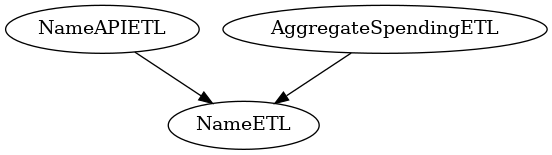

In [24]:
import pydot
from IPython.display import Image, display


def create_image(graph):
    return display(Image(graph.create_png()))


dot = pydot.Dot()
dot.add_node(pydot.Node(1, label="NameAPIETL"))
dot.add_node(pydot.Node(2, label="NameETL"))
dot.add_node(pydot.Node(3, label="AggregateSpendingETL"))
dot.add_edge(pydot.Edge(1, 2))
dot.add_edge(pydot.Edge(3, 2))

create_image(dot)

We could of course just track these manually, however it will get a bit complicated to keep track of all of this logic, instead we prefer to just keep track of "dependencies" and then let the system figure out what to run when.  Good systems will:

- Parallelize when possible
- Have retry logic
- Altering and observability


There are MANY really good libraries for processing and managing of python processes (airflow, prefect, dagster, etc...).  

However, we will just roll our own very simple one for the sake of demonstration.

It will build a Directed acyclic graph (DAG) which is the standard data structure used to track such processes.


In [25]:
import networkx as nx

class DependencyManager:
    def __init__(self):
        self.g = nx.DiGraph()

    def add_process(self, name, process):
        self.g.add_node(name, process=process)

    def add_dep(self, a, b):
        """a DEPENDS ON b"""
        if a not in self.g or b not in self.g:
            raise ValueError("dependency must be registered")
        self.g.add_edge(b, a)

    def visualize(self):
        graph = nx.drawing.nx_pydot.to_pydot(self.g)
        return create_image(graph)

    def get_ordered(self):
        return nx.topological_sort(self.g)

    def run(self):
        for ele in self.get_ordered():
            print(f"RUNNING: {ele}")
            self.g.nodes[ele]["process"].run()
            print("COMPLETE")

/tmp/ipykernel_1966332/2274264932.py:17: DeprecationWarning: nx.nx_pydot.to_pydot depends on the pydot package, which has known issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  graph = nx.drawing.nx_pydot.to_pydot(self.g)


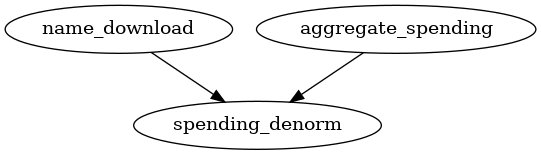

In [26]:
dm = DependencyManager()
dm.add_process("name_download", NameApiETL())
dm.add_process("aggregate_spending", AggregateSpendingETL())
dm.add_process("spending_denorm", NameETL())
 
dm.add_dep("spending_denorm", "name_download")
dm.add_dep("spending_denorm", "aggregate_spending")
dm.visualize()

Now we can get an execution order for our processes, we can do this via a technique called *topological ordering*

In [27]:
list(dm.get_ordered())

['name_download', 'aggregate_spending', 'spending_denorm']

In [28]:
dm.run()

RUNNING: name_download
COMPLETE
RUNNING: aggregate_spending
COMPLETE
RUNNING: spending_denorm
COMPLETE


### Frequency

Pipelines generally fall into one of three categories

- ad-hoc: run infrequently (maybe only once)
- batch: run frequently, typically with either a schedule or a trigger
- streaming: run constantly

# Pipelines for Projects

We can think of pipelines for projects as a type of "ad-hoc" pipelines, but still with many of the same standards.

A side of benefit of this, is that it might make it easier to take your projects to production.

A few tips:

## Data Management

Store data in an organized logical format, and notin random csv files scattered in directories.  

Some options are to use a database, or put the files in some hierarchical or folder structure with informative file/directory names and a README file.

Other considerations
- DO NOT alter your source data.  EVER.  Just don't do it.
- Disk space is cheap, make copies if you need with changes.
- Use macros and functions to improve modularity, reduce duplicate code, and improve code readability


## Process Management

Automate and manage your data transformation processes with:

- Makefile
- cli  (see `typer`, `click`)
- notebooks that can be run through in order (see `papermill`)
- cross-platform data transformation workflow tools such as [dbt labs](https://www.getdbt.com/)

The workflows should be efficient, with the use of parallel processing, caching to avoid regenerating unchanged intermediate results, and with failure/restart for long running pipelines.

Whichever process management platform you use, your code should be version controlled, documented,  code reviewed, and test.  This will avoid the situation of breaking code in production.  There is really no exception to this.

At any time you should be able to reproduce your results from the source system (or your local backup).

# Summary

Data pipelines is a vast subject, and we have barely scractched the surface here even in the more limited case of data transformation workflows for ML applications.


